_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-06-04, 9am

Name: Weiyi Xiao:{1}, Shanqian Ma:{2,3}

# Exercise sheet 6



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import zipf
from scipy.stats import poisson
from scipy.optimize import minimize, Bounds
mpl.rc("savefig", dpi=72)

import itertools

sns.set_style('whitegrid')
%matplotlib inline

## Task: Implement entropy estimators




### General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$s and $0$s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


### Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


In [2]:
def entropy_mle(phat):
    '''
    Maximum likelihood or plug-in estimator of discrete entropy
    
    phat:    estimate of the distribution / histogram
    H:       entropy estimate
    '''
    H=-phat[phat!=0]@np.log2(phat[phat!=0])

    
    return H


In [3]:
def entropy_mm(phat, n):
    '''
    Miller-Maddow corrected estimator of discrete entropy
    
    phat:    estimate of the distribution / histogram
    n:       sample size
    H:       entropy estimate
    '''
    dhat=len(phat[phat>0])

    H=entropy_mle(phat)+(dhat-1)/(2*n)
    
    return H


In [4]:
def entropy_jk(x, edges):
    '''
    Jack-knife corrected estimator of discrete entropy
    

    '''

    S = len(x)
    c_hat = np.histogram(x,edges)[0]
    c_hat = c_hat[c_hat>0]
    phat = c_hat / S
    h_mle = entropy_mle(phat)
    h_mle_jk = np.zeros(len(c_hat))
    for i in range(len(c_hat)):
        c_hat_copy = c_hat.copy()
        c_hat_copy[i]-=1
        phat = c_hat_copy / (S-1)
        h_mle_jk[i] = entropy_mle(phat)
    H_hat = np.dot(c_hat,h_mle_jk) / S
    
    H = S*h_mle-(S-1)*H_hat

    return H

In [5]:
def entropy_cae(phat, n):
    '''
    coverage-adjusted estimator of discrete entropy
    
    phat:    estimate of the distribution / histogram
    n:       sample size
    H:       entropy estimate
    '''
    numOnes = np.sum(phat==(1/n))
    c = 1 - numOnes/n
    pc=phat*c
    h=np.zeros(len(pc!=0))
    for i in np.where(pc!=0):
        #print(i)
        h[i]=-pc[i]*np.log2(pc[i])/(1-(1-pc[i])**n)
    H=np.sum(h)
    return H
    
    
    

In [6]:
import est_entro as ee
from scipy.stats import randint
def entropy_jvwh(x):
    '''
    JVHW estimator of discrete entropy

    '''
    H=ee.est_entro_JVHW(x)
    
    return H

Try to implement the unseen estimator, but somehow it doesn't work

In [7]:
def makeFinger(v):
# Input: vector of integers, v 
# Output: vector of fingerprints, f where f(i) = |{j: ... |{k:v(k)=j}|=i }| 
# i.e. f(i) is the number of elements that occur exactly i ... times 
# in the vector v 
    h1 = np.bincount(v)  # bin count returns [#0, #1, #2,...]
    f = np.bincount(h1)[1:]
    return f

In [8]:
def unseen(f):
# Input: fingerprint f, where f(i) represents number of elements that 
# appear i times in a sample. Thus sum_i i*f(i) = sample size. 
# File makeFinger.m transforms a sample into the associated fingerprint. 
# 
# Compute approximation of 'histogram' of true distribution. Specifically, 
# histx(i) represents the number of domain elements that occur with 
# probability x(i). Thus sum_i x(i)*histx(i) = 1, as distributions have 
# total probability mass 1. 
# 
# return Entropy
# An approximation of the entropy of the true distribution can be computed 
# as: Entropy = (-1)*sum(histx.*x.*log(x)) 
    k =  np.dot(f,np.arange(1,len(f)+1))  #total sample size
    gridFactor = 1.1  # the grid of probabilities will be geometric, with this ratio. 
    alpha = .5  # the allowable discrepancy between the returned solution and the "best" (overfit). 
    xLPmin = 1/(k*max(10,k)) # minimum allowable probability.
    maxLPIters = 1000  # the 'MaxIter' parameter for Matlab's 'linprog' LP solver. 2
    x=0
    histx = 0
    fLP = np.zeros(len(f))
    # Split the fingerprint into the 'dense' portion for which we 
    # solve an LP to yield the corresponding histogram, and 'sparse' 
    # portion for which we simply use the empirical histogram 
    for i in range(1,len(f)+1):
        idx = i-1
        if f[idx]>0:
            wind = [max(1,i-np.ceil(np.sqrt(i)))-1,min(i+np.ceil(np.sqrt(i)),len(f))-1]
            if sum(f[int(wind[0]):int(wind[1])+1]) < 2*np.sqrt(i):
                    x=[x, i/k]
                    histx=[histx,f[idx]]
                    fLP[idx]=0
            else:
                    fLP[idx]=f[idx]

    # If no LP portion, return the empirical histogram 

    if  np.where(fLP>0)[0].size >0:
        fmax = max(np.where(fLP>0)[0])
    else:
        x=x[1:end]
        histx=histx[1:end] 
        print('finish') # gai return x,histx

    # Set up the first LP 
    LPmass = 1 - np.dot(x,histx)  # amount of probability mass in the LP region 

    zero_padding = np.zeros(int(np.ceil(np.sqrt(fmax+1))))
    fLP=np.hstack((fLP[0:fmax+1],zero_padding))
    szLPf=fLP.size

    xLPmax = fmax/k
    power = np.arange(int(np.ceil(np.log(xLPmax/xLPmin)/np.log(gridFactor))+1))
    xLP=xLPmin*gridFactor**power
    szLPx=len(xLP) 

    objf=np.zeros(szLPx+2*szLPf)
    objf[szLPx::2]=1./(np.sqrt(fLP+1))  # discrepancy in ith fingerprint expectation 
    objf[szLPx+1::2]=1./(np.sqrt(fLP+1))  # weighted by 1/sqrt(f(i) + 1) 

    A = np.zeros((2*szLPf,szLPx+2*szLPf))
    b = np.zeros(2*szLPf)

    for i in range(szLPf): 
        A[2*i,0:szLPx]=poisson.pmf(i+1,k*xLP) 
        A[2*i+1,0:szLPx]=(-1)*A[2*i,0:szLPx] 
        A[2*i,szLPx+2*i]=-1
        A[2*i+1,szLPx+2*i+1]=-1
        b[2*i]=fLP[i]
        b[2*i+1]=-fLP[i] 

    Aeq = np.zeros(szLPx+2*szLPf)
    Aeq[0:szLPx]=xLP; 
    beq = LPmass

    for i in range(szLPx):
        A[:,i]=A[:,i]/xLP[i]; #rescaling for better conditioning 
        Aeq[i]=Aeq[i]/xLP[i]; 

    # res = linprog(objf, A, b, Aeq, beq, options={'maxiter':maxLPIters}), # can't use it because it only support 2D vector
    func = lambda x: np.dot(objf, x)
    cons=[]
    for i in range(b.size):
        cons.append({'type': 'ineq', 'fun' : lambda x: -np.dot(A[i,:], x) + b[i]})

    cons.append({'type': 'eq', 'fun' : lambda x: np.dot(Aeq, x) - beq})
    x0=np.zeros(szLPx+2*szLPf)
    lb = np.zeros(szLPx+2*szLPf)
    ub = np.inf*np.ones(szLPx+2*szLPf)
    bnds = Bounds(lb,ub)
    res = minimize(func, x0, method='SLSQP', bounds=bnds, constraints=cons,options={'maxiter':maxLPIters})

    sol = res.x
    fval = res.fun
    exitflag = res.status
    if exitflag ==9:
        print('maximum number of iterations reached--try increasing maxLPIters')

    if (exitflag !=0) & (exitflag !=9):
        print('LP1 solution was not found, still solving LP2 anyway...' )
        print(exitflag) 

    # Solve the 2nd LP, which minimizes support size subject to incurring at most 
    # alpha worse objective function value (of the objective function in the 
    # previous LP). 
    objf2=0*objf

    objf2[0:szLPx] = 1 
    A2=np.vstack((A,objf))  # ensure at most alpha worse obj value 
    b2=np.hstack((b, fval+alpha))  # than solution of previous LP 

    for i in range(szLPx): 
        objf2[i]=objf2[i]/xLP[i]  #rescaling for better conditioning 

    func2 = lambda x: np.dot(objf2, x)
    cons=[]
    for i in range(b2.size):
        cons.append({'type': 'ineq', 'fun' : lambda x: np.dot(A2[i,:], x) - b2[i]})

    cons.append({'type': 'eq', 'fun' : lambda x: np.dot(Aeq, x) - beq})
    x0 = sol
    res2 = minimize(func2, x0, method='SLSQP', bounds=bnds, constraints=cons,options={'maxiter':maxLPIters})
    sol2 = res2.x
    exitflag2 = res2.status
    if exitflag2!=0: 
        print('LP2 solution was not found') 
        print(exitflag2) 

    #append LP solution to empirical portion of histogram 
    sol2[0:szLPx]= sol2[0:szLPx]/ xLP  #removing the scaling 
    x=np.hstack((np.asarray(x),xLP))
    histx=np.hstack((np.asarray(histx),xLP))
    x = np.sort(x)
    ind = np.argsort(x)
    histx = histx[ind]
    x=x[histx>0]
    histx=histx[histx>0]

    estimatedEntropy = -np.dot(histx,np.multiply(x,np.log2(x)))

In [9]:
samp=np.random.choice(1024,100)
f = makeFinger(samp)
estimatedEntropy = unseen(f)
print(estimatedEntropy)

LP2 solution was not found
8
None


### Uniform distribution

In [10]:
D = 10
N = 2**D

p = 1/N * np.ones(N)   # true distribution

H = - np.sum(p * np.log2(p))  # true entropy
print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (1 pt)

#### Answer: the distribution with size=100 is too sparse to simulate the true distribution. For the number appeared once in samples, the probability is 0.01 which is much larger than the true probability 1/1024; and for the number did't appear in samples, the probability is 0 which is much smaller than true probability. While for the distribution with size 10000, the probability is more balanced and close to the true probability.

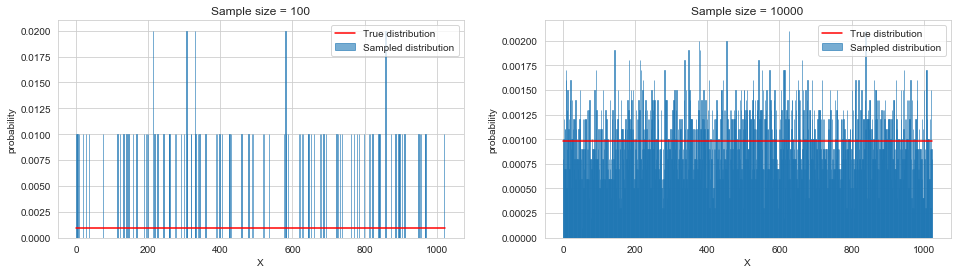

In [11]:
n_sample1=100
n_sample2=10**4
U_distr1=np.random.choice(N,n_sample1)
U_distr2=np.random.choice(N,n_sample2)
edges = np.arange(-0.5, N, 1)

plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
#sns.distplot(U_distr1,bins=20,kde=False,norm_hist=True,label='Sampled distribution')
plt.hist(U_distr1,bins=edges,density=True,alpha=0.6,edgecolor='C0',label='Sampled distribution')  #'C0' is the default blue #1f77b4
plt.plot(np.arange(0,N),p,color='r',label='True distribution')
plt.xlabel('X')
plt.ylabel('probability')
plt.title('Sample size = 100')
plt.legend()

plt.subplot(1,2,2)
#sns.distplot(U_distr2,bins=20,kde=False,norm_hist=True,label='Sampled distribution')
plt.hist(U_distr2,bins=edges,density=True,alpha=0.6,edgecolor='C0',label='Sampled distribution')  
plt.plot(np.arange(0,N),p,color='r',label='True distribution')
plt.xlabel('X')
plt.ylabel('probability')
plt.title('Sample size = 10000')
plt.legend()
plt.show()

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [12]:
sampleSz = np.round(np.logspace(1,5,num=10))
nRuns = 30

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sampleSz),nRuns))
h_mm = np.zeros((len(sampleSz),nRuns))
h_jk = np.zeros((len(sampleSz),nRuns))
h_cae = np.zeros((len(sampleSz),nRuns))
h_jvhw = np.zeros((len(sampleSz),nRuns))

for i, S in enumerate(sampleSz):
    print('sample size for this loop is: ' ,S)
    for j in np.arange(nRuns):
        
        # add sampling here...        
        x=np.random.choice(N,int(S))
        
        phat = np.histogram(x,edges)[0]
        phat = phat / S
        
        h_mle[i,j] = entropy_mle(phat)
        h_mm[i,j] = entropy_mm(phat, S)
        h_cae[i,j] = entropy_cae(phat, S)
        h_jk[i,j] = entropy_jk(x, edges)
        h_jvhw[i,j] = entropy_jvwh(x)



sample size for this loop is:  10.0
sample size for this loop is:  28.0
sample size for this loop is:  77.0
sample size for this loop is:  215.0
sample size for this loop is:  599.0
sample size for this loop is:  1668.0
sample size for this loop is:  4642.0
sample size for this loop is:  12915.0
sample size for this loop is:  35938.0
sample size for this loop is:  100000.0


Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

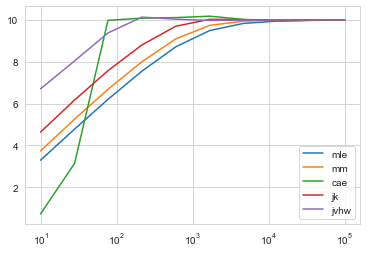

In [13]:
plt.semilogx(sampleSz,np.mean(h_mle, axis=1))

plt.semilogx(sampleSz,np.mean(h_mm, axis=1))
plt.semilogx(sampleSz, np.mean(h_cae, axis=1))
plt.semilogx(sampleSz,np.mean(h_jk, axis=1))
plt.semilogx(sampleSz,np.mean(h_jvhw, axis=1))


plt.legend(['mle', 'mm',  'cae', 'jk', 'jvhw'])


jvhw is the best for small sample size(i.e.<100), jvhw and cae have similar performance when sample size is between 100 and 10000, all estimators converge to the true entropy for large sample size (i.e. >10000)

### Zipf distribution

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (3 pts)

#### 1. In Zipf's distribution, smaller value (in the domain) have larger probability. 2. For sample size between 100-1000, jvhw and cae have similar performance when approximating the uniform distibution, but for the Zipf's distribution jvhw is better that cae. 3. All estimators converge faster (converged at a samller sample size) in the uniform case.

7.510649703297878


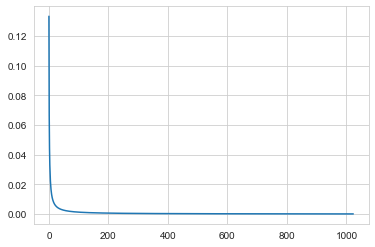

In [14]:
D = 10
N = 2**D

p = 1/(np.arange(0,N)+1)    # true distribution
s=np.sum(p)
p = p/np.sum(p)

plt.plot(np.arange(0,N),p)
H = - np.sum(p * np.log2(p))  # true entropy
print(H)


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `random.choice` is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? (1 pt)

#### when sample size = 10000, the sampled distribution is a good proximation of the true distribution.When sample size = 100, only a rough trend of the true distribution is observed (higher probability for small x, lower probability for large x). And again the probability value from the sampled distribution is constrained by the sample size, so it's not a good proximation of the true distibution.

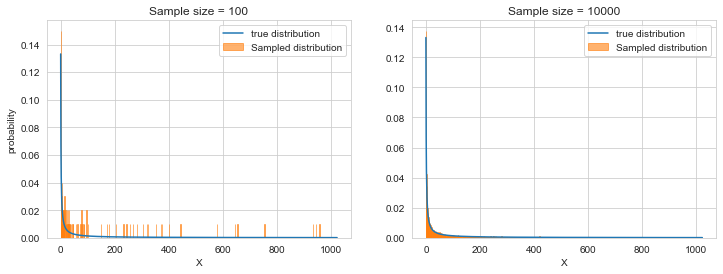

In [15]:
zipf1=np.random.choice(N, 100, p=list(p))
zipf2=np.random.choice(N, 10000, p=list(p))
edges = np.arange(-0.5, N, 1)

plt.figure(figsize=(12, 4))
c = mpl.colors.colorConverter.to_rgba('C1', alpha=0.6)
plt.subplot(1,2,1)
plt.plot(np.arange(0,N),p,label='true distribution')
plt.hist(zipf1,bins=edges,density=True,alpha=0.6,edgecolor=c,label='Sampled distribution')
plt.xlabel('X')
plt.ylabel('probability')
plt.title('Sample size = 100')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0,N),p,label='true distribution')
plt.hist(zipf2,bins=edges,density=True,alpha=0.6,edgecolor=c,label='Sampled distribution')
plt.xlabel('X')
plt.title('Sample size = 10000')
plt.legend()
plt.show()

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [16]:
sampleSz = np.round(np.logspace(1,5,num=10))
nRuns = 30

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sampleSz),nRuns))
h_mm = np.zeros((len(sampleSz),nRuns))
h_jk = np.zeros((len(sampleSz),nRuns))
h_cae = np.zeros((len(sampleSz),nRuns))
h_jvhw = np.zeros((len(sampleSz),nRuns))

for i, S in enumerate(sampleSz):
    for j in np.arange(nRuns):
        
        # add sampling here
        x=np.random.choice(1024, int(S), p=list(p))
        
        phat = np.histogram(x,edges)[0]
        
        phat = phat / S
        
        h_mle[i,j] = entropy_mle(phat)
        h_mm[i,j] = entropy_mm(phat, S)
        h_cae[i,j] = entropy_cae(phat, S)
        h_jk[i,j] = entropy_jk(x, edges)
        h_jvhw[i,j] = entropy_jvwh(x)
        


Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

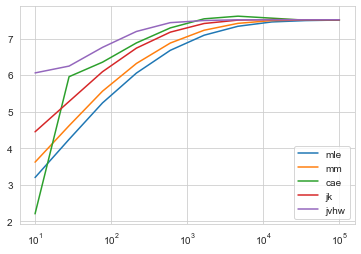

In [17]:
plt.semilogx(sampleSz,np.mean(h_mle, axis=1))

plt.semilogx(sampleSz,np.mean(h_mm, axis=1))
plt.semilogx(sampleSz, np.mean(h_cae, axis=1))
plt.semilogx(sampleSz,np.mean(h_jk, axis=1))
plt.semilogx(sampleSz,np.mean(h_jvhw, axis=1))


plt.legend(['mle', 'mm',  'cae', 'jk', 'jvhw'])
